### Campaign ROI Model

- Notebook Assumption 1: phone calls to leads are independent with respect to one another and we do not treat this as a time series problem
- Notebook Assumption 2: **the data scientist is working with the entire dataset of campaign phone calls, ranging from May 2008 to November 2010, and is performing the work after the campaign has ended e.g. December 2010**

- Task 1: create classification model to identify whether if a customer will subscribe to a term deposit offer
- Task 2: create a forecasting model using key economic variables to predict key economic indicators into the future
- Final Objective: calculate future marketing campaign ROI using task 1 and 2 as inputs

- A higher avg customer clv will allow for a proportionally lower decision threshold, and viceversa
- Duration cannot be used

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')
warnings.filterwarnings('ignore', 'Data with input dtype int64*')
warnings.filterwarnings('ignore', 'The default value*')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_pickle('data/data_ready.pickle')

In [7]:
df.drop('duration', axis=1, inplace=True)

In [8]:
#One more check: no nulls so no need to use imputers in pipeline
#df.isnull().sum()

In [9]:
#not just of type numeric, but actual numeric on a scale - excludes binary and ordinal categorical attributes
#the below attributes will be scaled in the Pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_total_days','month', 'day']

In [10]:
binary_features = ['biz_payday', 'govt_payday', 'is_holiday']

In [11]:
#outcome is y,n,unknown
categorical_features = ['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'month_last_contact', 'day_of_week_last_contact', 'holiday_name', 'weekday', 
                       'year']

In [12]:
label_binary = ['contact']

In [13]:
#passthrough = ['year', 'month', 'day']

In [14]:
#Models to be evaluated - can be modified/overridden to include more
def models():
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs', class_weight='balanced'), {'C':[0.01, 0.1, 1]})
    models['ridge'] = (RidgeClassifier(class_weight='balanced'), {'alpha':[0.01, 0.1, 1]})
    #models['svc'] = (SVC(class_weight='balanced'), {'C':[0.1, 1], 'gamma':['auto']})
    models['gaus_nb'] = (GaussianNB(), {'var_smoothing':[1e-9, 1]})
    models['bagging_class'] = (BaggingClassifier(), {'n_estimators':[7,12], 'max_samples':[1,5]})
    models['rf_class'] = (RandomForestClassifier(class_weight='balanced'), {'max_depth':[100, 1000], 'max_leaf_nodes':[10, 20, 30]})
    
    return models

In [15]:
#Split data between training and test sets
def split_data(df, target_name, test_size):

    X = df.drop(str(target_name), axis=1)
    y = df[str(target_name)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [16]:
def processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('label_binary', OneHotEncoder(sparse=False))])
    
    #intact_transformer = Pipeline(steps=[
    #    ('intact', )
    #])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, bin_features), 
        ('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', classifier)])

    return pipe

In [17]:
#Evaluate classifiers:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):

    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]

    new_param_grid = {}
    for i,k in param_grid.items():
        j = 'clf__'+i
        new_param_grid[j] = k

    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5, random_state=1)
    
    #Customization for timeseries: using TimeSeriesSplit
    #cv = TimeSeriesSplit(n_splits=2)

    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring=metric)

    gs.fit(X_train, y_train)

    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", gs.best_estimator_.named_steps['clf'])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))

    return cv_metric

In [18]:
#Main function to execute the workflow
def execute_spotcheck(df, target_name, test_size, numeric_features, categorical_features, bin_features, lab_bin_features):

    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)

    #Create a dictionary holding models that will be evaluated
    models_tested = models()

    model_results = {}

    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'accuracy')
        model_results[k] = cv_metric

    return model_results, models_tested

In [19]:
#Simple visualization of outcomes:
def visualize_results(model_results, models_tested):
    
    models_report = pd.DataFrame(model_results, columns=list(models_tested.keys()))
    
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [20]:
model_results, models_tested = execute_spotcheck(df, 'y', 0.3, numeric_features, categorical_features, binary_features, label_binary)


---------
Model Evaluated:  LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.831639926002385
Training accuracy Standard Dev with CV: 0.004977124838318824
Test Score: 0.835

---------
Model Evaluated:  RidgeClassifier(alpha=1, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)
Training accuracy Mean with CV: 0.828552936053787
Training accuracy Standard Dev with CV: 0.005386870764385511
Test Score: 0.832

---------
Model Evaluated:  GaussianNB(priors=None, var_smoothing=1)
Training accuracy Mean with CV: 0.8823833979244263
Training accuracy Standard Dev with CV: 0.0016205382267010123
Test Score: 0.882

---------
Model Evaluated:  Bagging

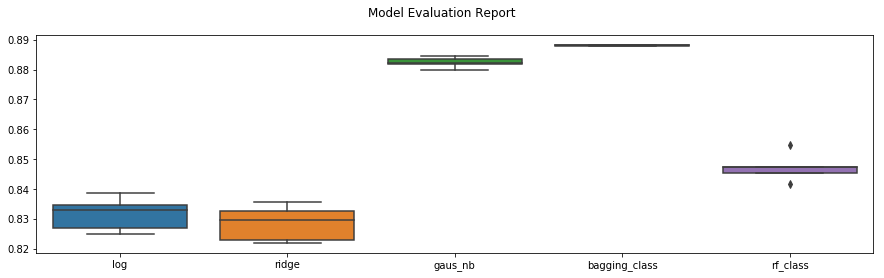

In [21]:
visualize_results(model_results, models_tested)

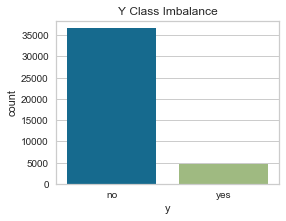

In [135]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="y", data=df)
plt.title('Y Class Imbalance')
plt.show()

GaussianNB and Bagging Classifier show better results, but they are not using stratified class sampling. Ridge Classifier and Random Forest Classifier show good results, but it's also worth examining SVM further. Next, we will analyze bias-complexity errors, classification reports, and try to pick one model to explore further refinement options such as feature engineering.

In [61]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [23]:
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)

In [24]:
#run this just once:
df_eval = df.copy()
y = df_eval.y
y = [1 if i == 'yes' else 0 for i in df_eval.y]
df_eval.drop('y', axis=1, inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_eval, y, test_size=0.3, random_state = 1)

Recreating the three classifiers with their best hyperparameters

In [26]:
best_lr = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [27]:
pipe_lr = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_lr)

In [32]:
best_rc = RidgeClassifier(alpha=1, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)

In [33]:
pipe_rc = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_rc)

In [38]:
best_rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=20, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [39]:
pipe_rf = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_rf)

Visualizing Model Results

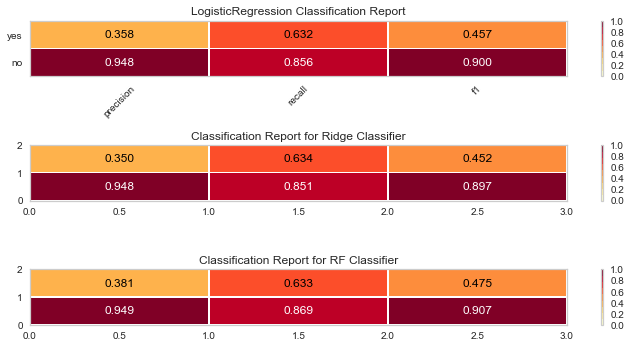

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [51]:
fig, axes = plt.subplots(3,1,figsize=(10,5))

cr_lr = ClassificationReport(pipe_lr, ax=axes[0], classes=['no', 'yes'])
cr_lr.fit(df_eval, y)
cr_lr.score(df_eval, y)

cr_rc = ClassificationReport(pipe_rc, ax=axes[1], classes=['no', 'yes'])
cr_rc.fit(df_eval, y)
cr_rc.score(df_eval, y)

cr_rf = ClassificationReport(pipe_rf, ax=axes[2], classes=['no', 'yes'])
cr_rf.fit(df_eval, y)
cr_rf.score(df_eval, y)

axes[1].set(title='Ridge Classifier Classification Report')
axes[2].set(title='RF Classifier Classification Report')

cr_lr.poof()
cr_rc.poof()
cr_rf.poof()

Learning curves are showing some variance for Ridge Classifier. Let's look at RandomForestClassifier next

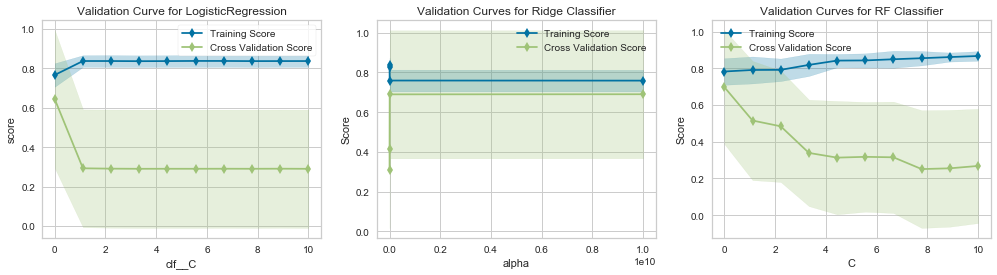

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_vc_lr = ValidationCurve(
    pipe_lr, param_name="clf__C",
    param_range=np.linspace(0.00001,10, 10), cv=cv, scoring="accuracy", ax=axes[0])

viz_vc_lr.fit(df_eval, y)

viz_vc_rc = ValidationCurve(
    pipe_rc, param_name="clf__alpha",
    param_range=np.logspace(0.001,10, 3), cv=cv, scoring="accuracy", ax=axes[1])

viz_vc_rc.fit(df_eval, y)

viz_vc_rf = ValidationCurve(
    pipe_rf, param_name="clf__max_depth",
    param_range=np.linspace(0.00001,10, 10), cv=cv, scoring="accuracy", ax=axes[2])

viz_vc_rf.fit(df_eval, y)

axes[1].set(title='Validation Curves for Ridge Classifier', xlabel='alpha', ylabel='Score')
axes[2].set(title='Validation Curves for RF Classifier', xlabel='C', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_vc_lr.poof()
viz_vc_rc.poof()
viz_vc_rf.poof()

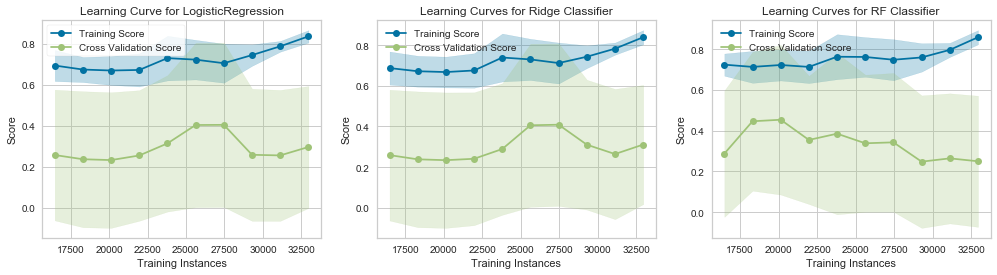

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_lc_lr = LearningCurve(
    pipe_lr, train_sizes = np.linspace(0.5, 1.0, 10), cv=cv, ax=axes[0]
)
# Fit and poof the visualizer
viz_lc_lr.fit(df_eval, y)

viz_lc_rc = LearningCurve(
    pipe_rc, train_sizes = np.linspace(0.5, 1.0, 10), cv=cv, ax=axes[1]
)
# Fit and poof the visualizer
viz_lc_rc.fit(df_eval, y)

viz_lc_rf = LearningCurve(
    pipe_rf, train_sizes = np.linspace(0.5, 1.0, 10), cv=cv, ax=axes[2]
)
# Fit and poof the visualizer
viz_lc_rf.fit(df_eval, y)

axes[1].set(title='Learning Curves for Ridge Classifier', xlabel='Training Instances', ylabel='Score')
axes[2].set(title='Learning Curves for RF Classifier', xlabel='Training Instances', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_lc_lr.poof()
viz_lc_rc.poof()
viz_lc_rf.poof()

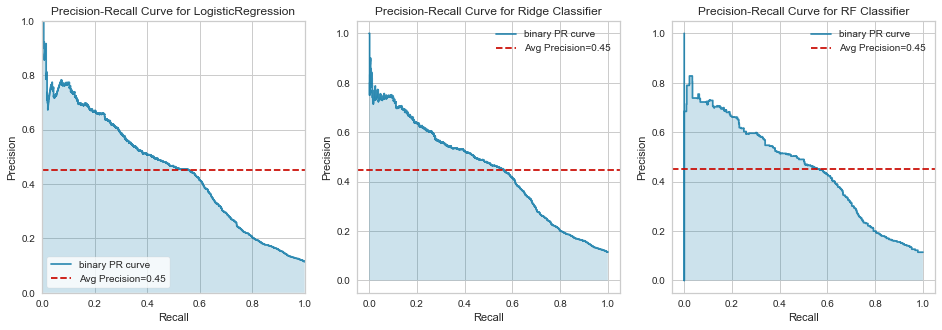

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

viz_pc_lr = PrecisionRecallCurve(pipe_lr, ax=axes[0])
viz_pc_lr.fit(X_train, y_train)
viz_pc_lr.score(X_test, y_test)

viz_pc_rc = PrecisionRecallCurve(pipe_rc, ax=axes[1])
viz_pc_rc.fit(X_train, y_train)
viz_pc_rc.score(X_test, y_test)

viz_pc_rf = PrecisionRecallCurve(pipe_rf, ax=axes[2])
viz_pc_rf.fit(X_train, y_train)
viz_pc_rf.score(X_test, y_test)

axes[1].set(title='Precision-Recall Curve for Ridge Classifier', xlabel='Recall', ylabel='Precision')
axes[2].set(title='Precision-Recall Curve for RF Classifier', xlabel='Recall', ylabel='Precision')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_pc_lr.poof()
viz_pc_rc.poof()
viz_pc_rf.poof()

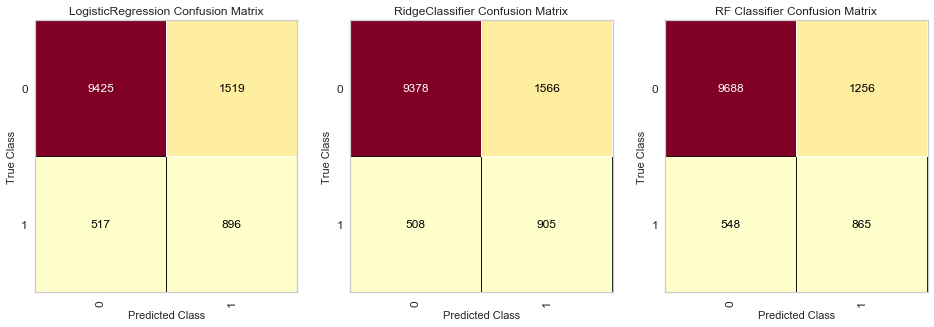

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

cm_lr = ConfusionMatrix(pipe_lr, classes=[0,1], ax=axes[0])
cm_lr.fit(X_train, y_train)
cm_lr.score(X_test, y_test)


cm_rc = ConfusionMatrix(pipe_rc, classes=[0,1], ax=axes[1])
cm_rc.fit(X_train, y_train)
cm_rc.score(X_test, y_test)


cm_rf = ConfusionMatrix(pipe_rf, classes=[0,1], ax=axes[2])
cm_rf.fit(X_train, y_train)
cm_rf.score(X_test, y_test)

axes[1].set(title='RidgeClassifier Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')
axes[2].set(title='RF Classifier Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

cm_lr.poof()
cm_rc.poof()
cm_rf.poof()

The learning curves above show a significant fact: generally, models seem to be improving up until instance 27500, when the learning curves begin diverging and thus the model shows higher and higher variance. This probably implies that a fundamental shift occurred around that time. Let's investigate more. 

In [73]:
df.iloc[27500, :][['year', 'month', 'day']]

year     2008
month      11
day        21
Name: 2008-11-21 00:00:00, dtype: object

Indeed, November 2008 saw the beginning of the dramatic Great Recession and it is very possible that fundamental factors affecting subcriptions to term deposits shifted, such as interest rates or global economic confidence

In [94]:
df_econ = df.iloc[22000:28000,:][['emp.var.rate','cons.conf.idx','euribor3m']]

In [95]:
df_econ.reset_index(inplace=True)

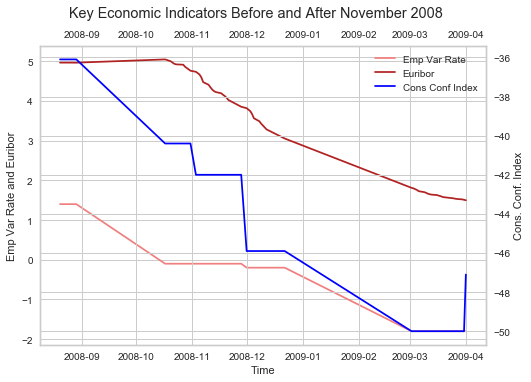

In [117]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Emp Var Rate and Euribor')
line1, = ax1.plot(df_econ.Date, df_econ['emp.var.rate'], color='lightcoral', label='Emp Var Rate')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()
line2, = ax2.plot(df_econ.Date, df_econ.euribor3m, color='firebrick', label='Euribor')
ax2.tick_params(axis='y')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax3.set_ylabel('Cons. Conf. Index')  # we already handled the x-label with ax1
line3, = ax3.plot(df_econ.Date, df_econ['cons.conf.idx'], color='blue', label='Cons Conf Index')
ax3.tick_params(axis='y')

plt.suptitle("Key Economic Indicators Before and After November 2008")

plt.legend(handles=[line1, line2, line3])
plt.show()

Although we treat each phone call (dataset instance) as independent, there were radical shifts in the economic environment that would motivate us to build a new model using only data occurring after November 2008 or even as early as September 2008

In [121]:
df_1 = df[(df['year'] == 2008) & (df['month'] < 10)]
df_2 = df[~df.index.isin(df_1.index)]

Recreating model evaluation pipeline for df_2:

In [128]:
model_results, models_tested = execute_spotcheck(df_2, 'y', 0.3, numeric_features, categorical_features, binary_features, label_binary)


---------
Model Evaluated:  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.7614897643480942
Training accuracy Standard Dev with CV: 0.002894181130584926
Test Score: 0.751

---------
Model Evaluated:  RidgeClassifier(alpha=0.01, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)
Training accuracy Mean with CV: 0.7618222664836708
Training accuracy Standard Dev with CV: 0.003121977009094647
Test Score: 0.749

---------
Model Evaluated:  GaussianNB(priors=None, var_smoothing=1)
Training accuracy Mean with CV: 0.8054520814637142
Training accuracy Standard Dev with CV: 0.005592936860215847
Test Score: 0.803

---------
Model Evaluated:  Baggi

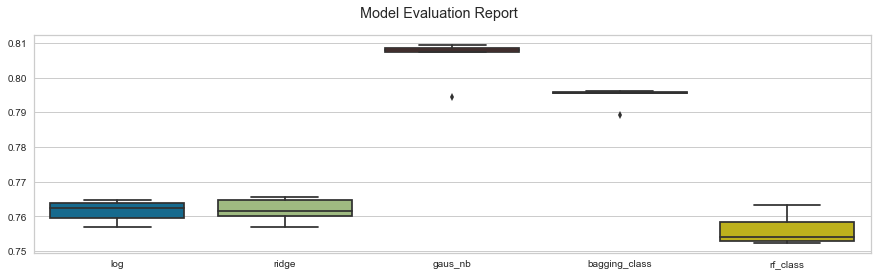

In [129]:
visualize_results(model_results, models_tested)

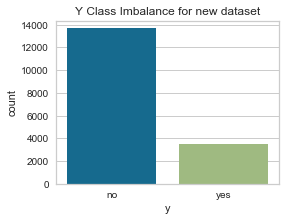

In [137]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="y", data=df_2)
plt.title('Y Class Imbalance for new dataset')
plt.show()

In [165]:
new_best_lr = LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

new_best_rc = RidgeClassifier(alpha=0.01, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)

In [166]:
new_pipe_lr = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, new_best_lr)
new_pipe_rc = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, new_best_rc)

In [167]:
#run this just once:
df_eval_2 = df_2.copy()
y_2 = df_eval_2.y
y_2 = [1 if i == 'yes' else 0 for i in df_eval_2.y]
df_eval_2.drop('y', axis=1, inplace=True)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(df_eval_2, y_2, test_size=0.3, random_state = 1)

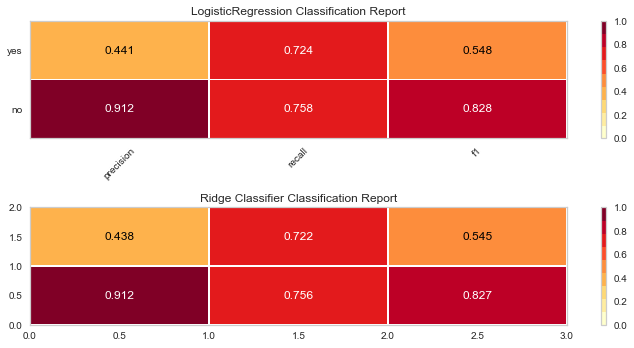

<Figure size 576x396 with 0 Axes>

In [177]:
fig, axes = plt.subplots(2,1,figsize=(10,5))

cr_lr = ClassificationReport(new_pipe_lr, ax=axes[0], classes=['no', 'yes'])
cr_lr.fit(X_train, y_train)
cr_lr.score(X_test, y_test)

cr_rc = ClassificationReport(new_pipe_rc, ax=axes[1], classes=['no', 'yes'])
cr_rc.fit(X_train, y_train)
cr_rc.score(X_test, y_test)

axes[1].set(title='Ridge Classifier Classification Report')

cr_lr.poof()
cr_rc.poof()

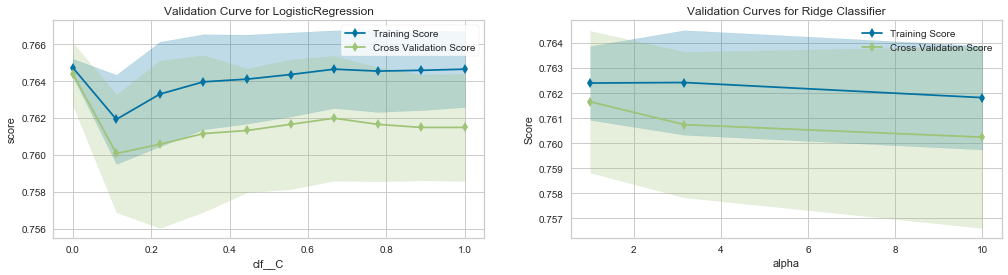

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

viz_vc_lr = ValidationCurve(
    new_pipe_lr, param_name="clf__C",
    param_range=np.linspace(0.00001,1, 10), cv=cv, scoring="accuracy", ax=axes[0])

viz_vc_lr.fit(X_train, y_train)

viz_vc_rc = ValidationCurve(
    new_pipe_rc, param_name="clf__alpha",
    param_range=np.logspace(0.001,1, 3), cv=cv, scoring="accuracy", ax=axes[1])

viz_vc_rc.fit(X_train, y_train)

axes[1].set(title='Validation Curves for Ridge Classifier', xlabel='alpha', ylabel='Score')
axes[1].legend().set_visible(True)

viz_vc_lr.poof()
viz_vc_rc.poof()

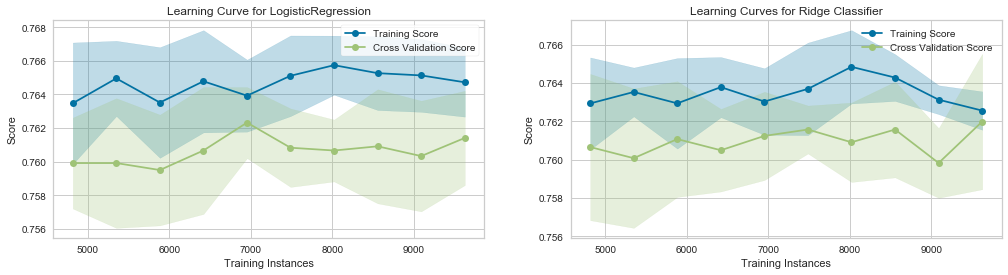

In [179]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

viz_lc_lr = LearningCurve(
    new_pipe_lr, train_sizes = np.linspace(0.5, 1.0, 10), cv=cv, ax=axes[0]
)
# Fit and poof the visualizer
viz_lc_lr.fit(X_train, y_train)

viz_lc_rc = LearningCurve(
    new_pipe_rc, train_sizes = np.linspace(0.5, 1.0, 10), cv=cv, ax=axes[1]
)
# Fit and poof the visualizer
viz_lc_rc.fit(X_train, y_train)

axes[1].set(title='Learning Curves for Ridge Classifier', xlabel='Training Instances', ylabel='Score')
axes[1].legend().set_visible(True)

viz_lc_lr.poof()
viz_lc_rc.poof()

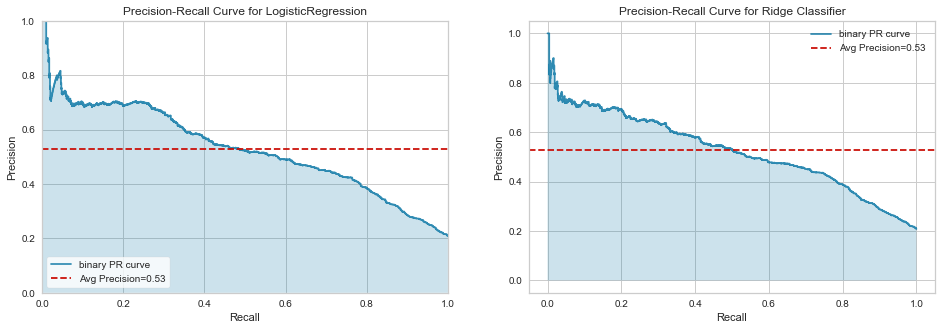

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(16,5))

viz_pc_lr = PrecisionRecallCurve(new_pipe_lr, ax=axes[0])
viz_pc_lr.fit(X_train, y_train)
viz_pc_lr.score(X_test, y_test)

viz_pc_rc = PrecisionRecallCurve(new_pipe_rc, ax=axes[1])
viz_pc_rc.fit(X_train, y_train)
viz_pc_rc.score(X_test, y_test)

axes[1].set(title='Precision-Recall Curve for Ridge Classifier', xlabel='Recall', ylabel='Precision')
axes[1].legend().set_visible(True)

viz_pc_lr.poof()
viz_pc_rc.poof()

In [ ]:
Compare train test split with stratification

Tune According to Campaign ROI as defined by differenced between avg loan and deposit interest rates and fixed/var campaign costs

In [42]:
clf = LogisticRegression(C=1, max_iter=100, class_weight = 'balanced')

In [43]:
clf.fit(X,y)

NameError: name 'X' is not defined

In [ ]:
y_pred = pipe.predict(df_eval)

In [ ]:
def make_conf_matrix(clf, X,y):
    y_pred = clf.predict(X)
    cmx = pd.DataFrame(confusion_matrix(y, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [ ]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

In [ ]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(pipe, df_eval, y)
plot_conf_matrix(cmx)

In [ ]:
print("Campaign Targets:", cmx.iloc[1,1]+cmx.iloc[0,1])

In [ ]:
accept_est = cmx.iloc[1,1]
reject_est = cmx.iloc[0,1]
total_targeted = accept_est+reject_est

In [ ]:
#enhancement: create rolling window logistic regression predicting next month's subscriptions

In [ ]:
Xex = df_eval[['year','month','age','job','marital']]

In [ ]:
Xex.head()

In [ ]:
Xex.reset_index(drop=0, inplace=True)

In [ ]:
y = y.reset_index(drop=1)

In [ ]:
clf = LogisticRegression(solver='sag')

In [ ]:
Xex.drop(columns='Date',inplace=True)

In [ ]:
clf.fit(Xex,y)

In [ ]:
clf.predict(np.array([1,2,3,1,1]).reshape(1,-1))

In [ ]:
#for each value in decision threshold range, 
    #create logistic regression
    #calculate profit for campaign with average CLV for next x months
#select the logistic regression yielding the highest ROI

Campaign ROI Calculation

In [ ]:
%store -r 'pred_clv'

In [ ]:
customers_monthly = df[['year','month','day']].groupby(by=['year','month']).count()
customers_monthly = customers_monthly.reset_index()
customers_monthly.rename(columns = {'day':'count'},inplace=True)
customers_monthly.head()

In [ ]:
customers_monthly['perc_of_total'] = customers_monthly['count']/customers_monthly['count'].sum()

In [ ]:
def calc_revenue(accept_est, pred_clv):
    return accept_est*pred_clv     

In [ ]:
#calculate revenue on a monthly basis comparing with predicted customer clv
#compare y with y pred and do a monthly classification matrix

In [ ]:
revenue_est = calc_revenue(customers_monthly['count'], pred_clv)

In [ ]:
revenue_est

In [ ]:
def calc_